## JSMA

2025-05-28 13:47:45.019683: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-28 13:47:45.019779: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-28 13:47:45.021321: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-28 13:47:45.029883: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-28 13:47:46.348605: W tensorflow/compiler/tf2

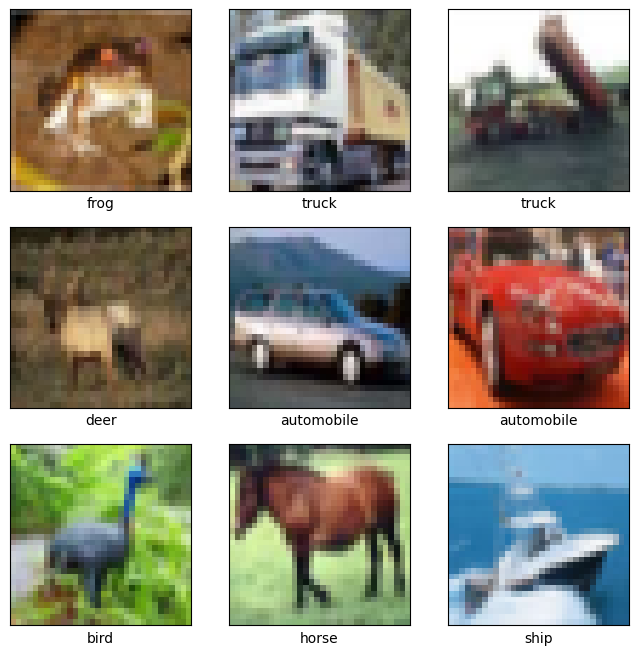

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Define class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Visualize the first 9 images
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[int(y_train[i].item())])
plt.show()

In [2]:
# Import libraries
import torch
import torchvision.transforms as transforms
from torchvision import models

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])# Define transforms: resize, convert to tensor, normalize


# Example: transform a single image
img = x_train[0]  # numpy array
img_tensor = transform(img)  # shape: (3, 224, 224)

In [3]:
print(torch.cuda.is_available())  # Should be True
print(torch.cuda.device_count())  # Should be > 0
print(torch.cuda.get_device_name(0))  # Should return GPU name
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
4
NVIDIA A100-SXM4-80GB


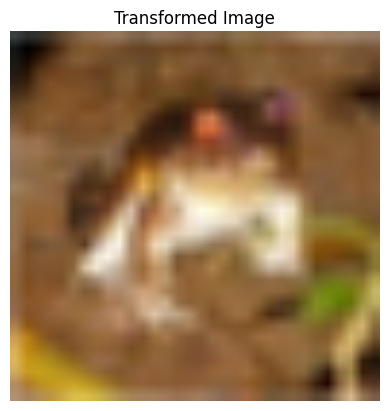

In [4]:
# Show a transformed image (after resizing and normalization)
import torchvision.transforms.functional as F

# Undo normalization for visualization
def unnormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406], device=img_tensor.device).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225], device=img_tensor.device).view(3,1,1)
    return img_tensor * std + mean

# Transform and show the image
img = x_train[0]
img_tensor = transform(img)
img_unnorm = unnormalize(img_tensor)

# Convert to numpy for matplotlib (C, H, W) -> (H, W, C)
img_np = img_unnorm.permute(1, 2, 0).numpy()
img_np = np.clip(img_np, 0, 1)

plt.imshow(img_np)
plt.title("Transformed Image")
plt.axis('off')
plt.show()

In [5]:
import torch.nn as nn
from torchvision.models import GoogLeNet_Weights

# Load GoogleLeNet with the recommended weights argument
model_base = models.googlenet(weights=GoogLeNet_Weights.IMAGENET1K_V1)

# Change the final fully connected layer for 10 classes (CIFAR-10)
model_base.fc = nn.Linear(model_base.fc.in_features, 10)
for name, param in model_base.named_parameters():
    if name.startswith(('conv1', 'conv2', 'inception3a', 'inception3b')):
        param.requires_grad = False

In [6]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class CIFAR10TorchDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = int(self.labels[idx].item())  # Fix: use .item() to get scalar
        if self.transform:
            img = self.transform(img)
        return img, label

# Flatten y_train for stratification
y_train_flat = y_train.flatten()

# Split train into train/val (80/20) with stratification
x_train_split, x_val, y_train_split, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train_flat
)

# Create PyTorch datasets for train and validation
train_dataset = CIFAR10TorchDataset(x_train_split, y_train_split, transform=transform)
val_dataset = CIFAR10TorchDataset(x_val, y_val, transform=transform)
test_dataset = CIFAR10TorchDataset(x_test, y_test, transform=transform)
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
# Get a single batch from train_loader
for images, labels in test_loader:
    print("Image batch shape:", images.shape)  # (batch_size, channels, height, width)
    print("Label batch shape:", labels.shape)
    break

Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])


In [8]:
model_path = "best_model_googleLenet.pth"
model_base.to(device)
model_base.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model_base.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [9]:
from art.attacks.evasion import SaliencyMapMethod
from art.estimators.classification import PyTorchClassifier
import torch.optim as optim

learning_rate = 1e-4

classifier = PyTorchClassifier(
    model=model_base,
    loss=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(model_base.parameters(), lr=learning_rate),
    input_shape=(3, 224, 224),  
    nb_classes=10,
)

attack = SaliencyMapMethod(classifier=classifier, theta=0.1, gamma=1, batch_size=1, verbose=True)

/home/jovyan/.conda/envs/tesi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
for images, labels in test_loader:
    label_indices = labels.numpy()  # Convert to numpy array
    label_names = [class_names[idx] for idx in label_indices]
    print("Label indices:", label_indices)
    print("Label names:", label_names)
    break 

Label indices: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5 2 4 0 9 6 6 5]
Label names: ['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile', 'airplane', 'truck', 'dog', 'horse', 'truck', 'ship', 'dog', 'horse', 'ship', 'frog', 'horse', 'airplane', 'deer', 'truck', 'dog', 'bird', 'deer', 'airplane', 'truck', 'frog', 'frog', 'dog']


In [11]:
confusion_dict = {
    "airplane": "ship",
    "automobile": "truck",
    "bird": "cat",
    "cat": "dog",
    "deer": "cat",
    "dog": "cat",
    "frog": "cat",
    "horse": "deer",
    "ship": "airplane",
    "truck": "automobile"
}

In [204]:
# Get one batch from the test loader
for x_batch, y_batch in test_loader:
    break  # Only take the first batch

# Convert to NumPy and scale to [0, 1] if needed
x_np = x_batch.numpy().astype(np.float32)

# Use label indices (optional, but recommended)
y_np = y_batch.numpy()  # shape (batch_size,)

y_target = np.array([
    class_names.index(confusion_dict[class_names[y]]) for y in y_np
])

# Now you can use y_target as the y input for attack.generate
x_adv = attack.generate(x=x_np, y=y_target)


print("Adversarial image shape:", x_adv.shape)

JSMA: 100%|██████████| 32/32 [05:47<00:00, 10.86s/it]

Adversarial image shape: (32, 3, 224, 224)


In [12]:
def get_predicted_labels(model, x_adv, device):
    """
    Given adversarial examples and a model, returns the predicted labels.
    Args:
        model: PyTorch model (should be in eval mode)
        x_adv: torch.Tensor or np.ndarray, shape (N, C, H, W)
        device: torch.device
    Returns:
        preds: np.ndarray of predicted label indices, shape (N,)
    """
    import torch
    if isinstance(x_adv, np.ndarray):
        x_adv = torch.tensor(x_adv, dtype=torch.float32)
    x_adv = x_adv.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(x_adv)
        preds = outputs.argmax(dim=1).cpu().numpy()
    return preds

y_adv = get_predicted_labels(model_base, x_adv, device)

NameError: name 'x_adv' is not defined

In [224]:
def plot_images_grid_with_psnr(clean_imgs, adv_imgs, clean_preds, adv_preds, labels, attack_name, psnr_list):
    import matplotlib.pyplot as plt
    import numpy as np
    import torch

    num_images = len(clean_imgs)
    fig, axes = plt.subplots(num_images, 3, figsize=(12, 4 * num_images))
    fig.suptitle(f"{attack_name} Attack", fontsize=18, y=1.02)

    if num_images == 1:
        axes = np.expand_dims(axes, 0)

    for i in range(num_images):
        img_clean = clean_imgs[i]
        img_adv = adv_imgs[i]
        if not isinstance(img_clean, torch.Tensor):
            img_clean = torch.tensor(img_clean)
        if not isinstance(img_adv, torch.Tensor):
            img_adv = torch.tensor(img_adv)
        img_clean_unnorm = np.clip(unnormalize(img_clean).cpu().numpy(), 0, 1)
        img_adv_unnorm = np.clip(unnormalize(img_adv).cpu().numpy(), 0, 1)
        # Amplify perturbation for visualization
        perturbation = img_adv_unnorm - img_clean_unnorm
        perturbation_vis = np.transpose(perturbation, (1, 2, 0))
        # Scale for visibility (e.g., 10x) and center at 0
        perturbation_vis = np.clip(perturbation_vis * 10 + 0.5, 0, 1)

        # Clean
        axes[i, 0].imshow(np.transpose(img_clean_unnorm, (1, 2, 0)))
        axes[i, 0].set_title(f"Clean\nPred: {clean_preds[i]}\nTrue: {labels[i]}")
        axes[i, 0].axis('off')
        # Adversarial
        axes[i, 1].imshow(np.transpose(img_adv_unnorm, (1, 2, 0)))
        axes[i, 1].set_title(f"Adversarial\nPred: {adv_preds[i]}\nTrue: {labels[i]}")
        axes[i, 1].axis('off')
        # Perturbation + PSNR (use amplified difference and a diverging colormap)
        axes[i, 2].imshow(perturbation_vis)
        axes[i, 2].set_title(f"Perturbation\nPSNR: {psnr_list[i]:.2f}")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

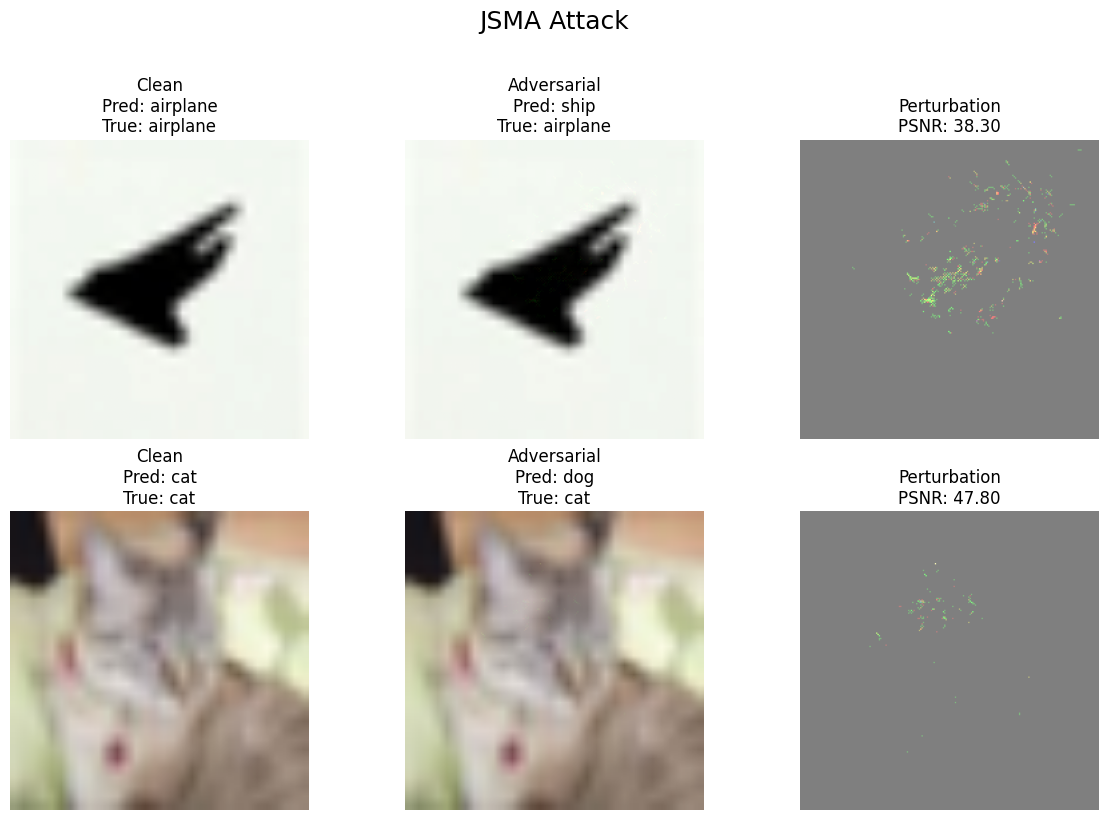

In [225]:
from skimage.metrics import peak_signal_noise_ratio as psnr

# Suppose x_np, x_adv, y_np, y_adv, class_names are available
num_images = x_np.shape[0]
clean_preds = [class_names[i] for i in get_predicted_labels(model_base, x_np, device)]
adv_preds = [class_names[i] for i in y_adv]
labels = [class_names[i] for i in y_np]
attack_name = "JSMA"

# Compute PSNR for each image
psnr_list = []
for i in range(num_images):
    img_clean = np.transpose(x_np[i], (1,2,0))
    img_adv = np.transpose(x_adv[i], (1,2,0))
    psnr_list.append(psnr(img_clean, img_adv, data_range=1.0))

import random

# Number of images to show
num_show = 2
indices = random.sample(range(num_images), num_show)

# Select random images and corresponding data
x_np_sel = [x_np[i] for i in indices]
x_adv_sel = [x_adv[i] for i in indices]
clean_preds_sel = [clean_preds[i] for i in indices]
adv_preds_sel = [adv_preds[i] for i in indices]
labels_sel = [labels[i] for i in indices]
psnr_list_sel = [psnr_list[i] for i in indices]

plot_images_grid_with_psnr(
    x_np_sel, x_adv_sel, clean_preds_sel, adv_preds_sel, labels_sel, attack_name, psnr_list_sel
)

In [208]:
def accuracy_on_adversarial(model, x_adv, y_true, device):
    """
    Computes accuracy of the model on adversarial examples.
    Args:
        model: PyTorch model
        x_adv: np.ndarray, shape (B, C, H, W)
        y_true: np.ndarray, shape (B,)
        device: torch.device
    Returns:
        accuracy: float (0-1)
    """
    import torch
    model.eval()
    with torch.no_grad():
        x_adv_tensor = torch.tensor(x_adv).to(device)
        y_true_tensor = torch.tensor(y_true).to(device)
        outputs = model(x_adv_tensor)
        preds = outputs.argmax(dim=1)
        correct = (preds == y_true_tensor).sum().item()
        total = y_true_tensor.size(0)
        accuracy = correct / total
    return accuracy

# Example usage after generating x_adv:
acc = accuracy_on_adversarial(model_base, x_adv, y_np, device)
print(f"Accuracy on adversarial examples: {acc*100:.2f}%")

Accuracy on adversarial examples: 3.12%


In [ ]:
x_all_adv = []
y_all = []

for x_batch, y_batch in test_loader:
    # Convert to NumPy and scale to [0, 1] if necessario
    x_np = x_batch.numpy().astype(np.float32)
    y_np = y_batch.numpy()

    # Calcolo del target per ogni esempio nel batch
    y_target = np.array([
        class_names.index(confusion_dict[class_names[y]]) for y in y_np
    ])

    # Generazione degli esempi avversariali
    x_adv = attack.generate(x=x_np, y=y_target)

    x_all_adv.append(x_adv)
    y_all.append(y_np)

# Concatenazione dei risultati
x_adv_all = np.concatenate(x_all_adv, axis=0)
y_all = np.concatenate(y_all, axis=0)



#Salvataggio con torch
torch.save(torch.tensor(x_adv_all), "x_all_adv.pt")
torch.save(torch.tensor(y_all), "y_all.pt")
print("Dati salvati: x_all_adv.pt e y_all.pt")


In [45]:
"""
x_adv_all = torch.load("x_adv_all.pt")
y_adv_all = torch.load("y_adv_all.pt")
"""


/tmp/ipykernel_443577/3124814933.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_adv_all = torch.load("x_adv_all.pt")
/tmp/ipykernel_443577/3124814933.py:2: FutureWarn

In [49]:
acc = accuracy_on_adversarial(model_base, x_all_adv, y_all, device)
print(f"Accuracy on adversarial examples: {acc*100:.2f}%")

Accuracy on adversarial examples: 99.54%


In [48]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import torch

# -----------------------------
# Funzione per il calcolo del PSNR
# -----------------------------
def compute_psnr(x_clean, x_adv):
    mse = np.mean((x_clean - x_adv) ** 2, axis=(1, 2, 3))
    psnr = 20 * np.log10(1.0 / (np.sqrt(mse) + 1e-8))
    return psnr

# -----------------------------
# Parametri e inizializzazione
# -----------------------------
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

agg_conf = np.zeros((10, 10), dtype=int)
psnr_per_class = {}
results = []

# -----------------------------
# Esecuzione attacco JSMA
# -----------------------------

# PSNR
# Ricostruzione delle immagini "pulite" (x_clean)
x_clean_list = []
for images, _ in test_loader:
    x_clean_list.append(images.numpy())
x_clean_np = np.concatenate(x_clean_list, axis=0)
psnr_all = compute_psnr(x_clean=x_clean_np, x_adv=x_adv_all)

# Predizioni
from torch.utils.data import DataLoader, TensorDataset

# Crea un DataLoader per i dati avversari
x_adv_tensor = torch.tensor(x_adv_all)
y_tensor = torch.tensor(y_all)
adv_dataset = TensorDataset(x_adv_tensor, y_tensor)
adv_loader = DataLoader(adv_dataset, batch_size=128)  # batch size regolabile

preds_all = []

model_base.eval()
with torch.no_grad():
    for x_batch, _ in adv_loader:
        x_batch = x_batch.to(device)
        outputs = model_base(x_batch)
        _, preds = torch.max(outputs, 1)
        preds_all.extend(preds.cpu().numpy())


# Confusion matrix
cm = confusion_matrix(y_all, preds_all, labels=list(range(10)))
agg_conf += cm

# Accuracy
acc = np.sum(preds_all == y_all) / len(y_all)
results.append({"attack": "JSMA", "accuracy": acc})

# PSNR per class
per_class = [[] for _ in range(10)]
for i in range(len(y_all)):
    per_class[y_all[i]].append(psnr_all[i])
psnr_per_class["JSMA"] = [np.mean(pc) if len(pc) > 0 else 0.0 for pc in per_class]

# -----------------------------
# Salva le metriche
# -----------------------------
metrics = {
    "jsma_agg_conf": agg_conf,
    "jsma_psnr_per_class": psnr_per_class,
    "class_names": class_names,
    "results": pd.DataFrame(results)
}

print("Metriche per JSMA calcolate con successo.")


Metriche per JSMA calcolate con successo.


In [50]:
# --- Aggregate confusion statistics (JSMA) ---
print("\nAggregate JSMA confusion:")
jsma_agg_conf = metrics["jsma_agg_conf"]
jsma_agg_df = pd.DataFrame(jsma_agg_conf, index=metrics["class_names"], columns=metrics["class_names"])
print(jsma_agg_df)

# --- Calculate mean PSNR per class ---
if "jsma_psnr_per_class" in metrics:
    mean_psnr_per_class = metrics["jsma_psnr_per_class"]
else:
    print("Warning: PSNR per-class metrics not found in metrics dict.")
    mean_psnr_per_class = None

# --- Per-class confusion summary with mean PSNR ---
agg_summary = []
for idx, row in enumerate(jsma_agg_conf):
    true_label = metrics["class_names"][idx]
    row_copy = row.copy()
    row_copy[idx] = 0
    total_confused = row_copy.sum()
    if total_confused == 0:
        most_confused = "-"
        count = 0
        percentage = 0.0
    else:
        most_confused_idx = np.argmax(row_copy)
        most_confused = metrics["class_names"][most_confused_idx]
        count = row_copy[most_confused_idx]
        percentage = 100.0 * count / total_confused

    mean_psnr = "-"
    if mean_psnr_per_class is not None:
        mean_psnr_val = mean_psnr_per_class.get(idx)
        if mean_psnr_val is not None:
            mean_psnr = f"{mean_psnr_val:.2f}"

    agg_summary.append({
        "True Label": true_label,
        "Most Confused With": most_confused,
        "Count": count,
        "Percentage": f"{percentage:.2f}%",
        "Mean PSNR": mean_psnr
    })

agg_df = pd.DataFrame(agg_summary)
print(agg_df.to_markdown(index=False))

# --- Show accuracy table (JSMA) ---
print("\nAccuracy Table (JSMA):")
df_results = metrics["results"]
print(df_results.to_markdown(index=False))



Aggregate JSMA confusion:
            airplane  automobile  bird  cat  deer  dog  frog  horse  ship  \
airplane         997           0     0    0     1    0     0      0     2   
automobile         0         999     0    0     0    0     0      0     0   
bird               1           0   993    2     3    1     0      0     0   
cat                1           0     0  990     1    4     3      1     0   
deer               0           0     0    1   996    1     1      1     0   
dog                0           0     1    5     0  992     0      2     0   
frog               0           0     0    2     1    0   997      0     0   
horse              1           0     1    0     1    1     0    996     0   
ship               1           2     0    0     0    0     0      0   997   
truck              0           2     0    0     0    0     0      0     0   

            truck  
airplane        0  
automobile      1  
bird            0  
cat             0  
deer            0  
dog  